### **For this assignment the only permitted libraries to use are Numpy, Scipy, MatplotLib and Pandas! Use of generative AI is not allowed.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

## Data loading

In [2]:
# Unzip train_data.npy, test_data.npy, val_data.npy
#!unzip all_data.zip

# Load the data
train_data = np.load('train_data.npy')
test_data = np.load('test_data.npy')
val_data = np.load('val_data.npy')

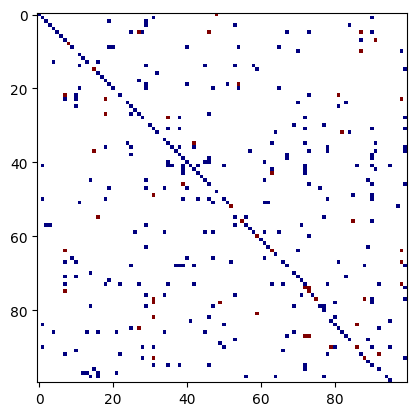

In [19]:
# Visualize the [user x user] arrays
cmap = cm.jet
cmap.set_bad('white',1.)

masked_array_train = np.ma.array(train_data, mask=np.isnan(train_data))
plt.imshow(masked_array_train[:100,:100], interpolation='nearest', cmap=cmap)
plt.pause(0.1)

In [21]:
# Further visualizations to justify your answers to the familiarization questions below
print(masked_array_train[8,8])

1.0


**Familiarization questions**

1.	What properties of the data do you think are important for your pipeline design? Think of the data sparsity and distribution of labels.

2.	What are some sources of sparsity in the data?

        The data is sparse likely because few people have been questioned.

3.	Do you see different types of people (in terms of both which id pairs are present and what they liked/didn’t like)?

        There is a diagonal of defined values 0/1, which seems to me like most people didn't like themselves, but a few did.

## WebLab solutions

In [5]:
# Solution: NMF routine (for unit test on weblab)

def nmf(X, n_components: int, max_iter: int=1000, tol: float=1e-3):
    """
    Decomposes the original sparse matrix X into two matrices W and H.
    """
    X = np.array(X)
    W = np.random.rand(X.shape[0], n_components)
    H = np.random.rand(n_components, X.shape[1])

    eps = 1e-9
    temp = W @ H
    e_old = np.linalg.norm(X - temp)
    for _ in range(max_iter):
        W *= (X @ H.T) / (temp @ H.T + eps)
        H *= (W.T @ X) / (W.T @ W @ H + eps)
        temp = W @ H
        e = np.linalg.norm(X - temp)
        if e_old - e < tol:
            break
        e_old = e

    return W, H

In [23]:
# Solution: Min-hashing routine (for unit test on weblab)
import sys

class HashFunction:
    """
    This HashFunction class can be used to create a unique hash given an alpha and beta.
    """
    def __init__(self, alpha, beta):
        self.alpha, self.beta = alpha, beta

    def hashf(self, x, n):
        """
        Returns a hash given integers x and n.
        :param x: The value to be hashed
        :param n: The number of unique ids of all sets
        :return: The hashed value x given alpha and beta
        """
        return (self.alpha * x + self.beta) % n

def compute_signature(hashes: list[HashFunction], ids: list[set[int]]):
    """
    This function will calculate the MinHash signature matrix from our sets of ids
    using the list of hash functions (hashes)
    :param hashes: The list of hash functions of arbitrary length
    :param ids: The list of sets of ids
    :return: The MinHash signature matrix for the given sets of ids
    """

    k = len(hashes)
    n = len(ids)
    result = np.full((k, n), sys.maxsize)
    sorted_space = sorted(set().union(*ids))
    slen = len(sorted_space)
    hashres = np.zeros(k)

    for u, user in enumerate(sorted_space):
        hashres[:] = [f.hashf(u, slen) for f in hashes]
        for i, likes in enumerate(ids):
            if user in likes:
                result[:, i] = np.minimum(result[:, i], hashres)

    return result

## NMF-based recommender system

In [7]:
# Step 1: NMF routine which can handle NaNs! (for the 'real data' NMF recommender system task)

def nmf_nan(X, n_components: int, max_iter: int=100, tol: float=1e-3):
    """
    Computes NMF of matrix X which includes 'unknown' NaN values.
    """
    X = np.array(X)
    X = np.ma.array(X, mask=np.isnan(X))
    W = np.random.rand(X.shape[0], n_components)
    H = np.random.rand(n_components, X.shape[1])

    eps = 1e-9
    temp = W @ H
    e_old = np.nansum((X - temp) ** 2)
    e = e_old
    for _ in range(max_iter):
        W *= np.ma.dot(X, H.T) / (temp @ H.T + eps)
        H *= np.ma.dot(W.T, X) / (W.T @ W @ H + eps)
        temp = W @ H
        e = np.nansum((X - temp) ** 2)
        if e_old - e < tol:
            break
        e_old = e

    return W, H, e

5 9704.858877492721
10 9233.354718234456
20 8626.953606276336
50 7459.576027926276
100 6138.02125635147


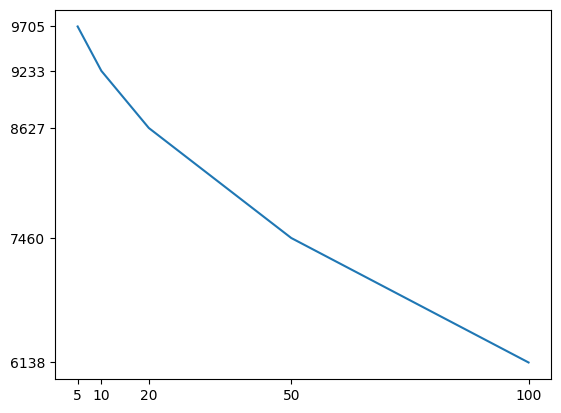

In [8]:
# Step 2: Fit train data

np.random.seed(5)
list_components = np.array([5,10,20,50,100])

# Compute nmf_nan() using the n_components in list_components, and following the instructions in the assignment pdf.
comp_options = len(list_components)
recons, errs = {}, []
for comp in list_components:
    w, h, err = nmf_nan(train_data, comp)
    print(comp, err)
    recons[comp] = w @ h
    errs.append(err)

# Plot the final reconstruction error as a function of n_components
plt.plot(list_components, errs)
plt.xticks(list_components)
plt.yticks(errs)
plt.show()

In [9]:
def accuracy(recon: np.ndarray, thr: float, baseline: np.ndarray) -> float:
    # flipped the > to <= so that the subtraction gives 0 iff the prediction is wrong, and preserves the nans
    return np.nanmean(np.abs((recon <= thr) - baseline))

In [18]:
def best_accuracy(recons: dict[(int, np.ndarray)], comps: list[int], thrs: list[float], baseline: np.ndarray) -> (float, int, float):
    b_acc, b_comp, b_thr = 0., None, None
    accs = []
    for comp in comps:
        recon = recons[comp]
        accs = []
        for thr in thrs:
            # Compute training accuracy
            acc = accuracy(recon, thr, baseline)
            accs.append(accs)
            print(acc)
            if acc > b_acc:
                b_acc = acc
                b_comp = comp
                b_thr = thr
    return b_acc, b_comp, b_thr

In [11]:
# Step 3: Get training accuracies

# Declare some list of thresholds to try: list_thr...
list_thr = [0.1, 0.25, 0.5, 0.75, 0.9]
best_acc, best_comp, best_thr = best_accuracy(recons, list_components, list_thr, train_data)
print(f'Best accuracy {best_acc} for {best_comp} components and threshold {best_thr}')

0.8429773674319797
0.8288912492850723
0.8231881689680529
0.8222894027289811
0.8221096494811667
0.8542201160225509
0.8365225917150094
0.8261949505678569
0.8233842634202141
0.8226325680202631
0.8677342920173217
0.8475365634447258
0.8328621619413351
0.8274041996895172
0.824887654220116
0.8924258517852766
0.8699240133997875
0.8495792139880709
0.8391862080235314
0.8328131383282948
0.9181959310401177
0.8950404444807583
0.8711822861344881
0.8576517689353705
0.8461802434839447
Best accuracy 0.9181959310401177 for 100 components and threshold 0.1


In [12]:
# Step 4: Get validation accuracies
# This is where we fit the n_components and the threshold
list_thr = [0.01, 0.1, 0.2, 0.3, 0.5]
best_acc, best_comp, best_thr = best_accuracy(recons, list_components, list_thr, val_data)
print(f'Best accuracy {best_acc} for {best_comp} components and threshold {best_thr}')

0.7829882257409663
0.835464880227365
0.82907023954527
0.8273447015834349
0.8270401948842875
0.7818717011774259
0.8384084449857897
0.8304912708079578
0.8285627283800243
0.8272431993503857
0.7825822168087698
0.8369874137231019
0.832318311002842
0.8294762484774665
0.8271416971173365
0.7820747056435241
0.8319123020706456
0.8308972797401543
0.8300852618757613
0.8270401948842875
0.7666463662200569
0.8301867641088104
0.8296792529435647
0.8285627283800243
0.8268371904181891
Best accuracy 0.8384084449857897 for 10 components and threshold 0.1


In [13]:
# Step 5: Get the final test accuracy
# We use the n_components and the threshold we fit on the validation set
comp, thr = best_comp, best_thr
# Compute test accuracy
test_accuracy = accuracy(recons[comp], thr, test_data)
print(f"Test accuracy: {test_accuracy:g}%, thr: {thr:g}, n_components: {comp}")

Test accuracy: 0.786598%, thr: 0.1, n_components: 10


## Distance-based recommender system

In [14]:
# Use min-hashing on the rows and find the nearest neighbors using Jaccard distance

# Use min-hashing on the columns and find the nearest neighbors using Jaccard distance

In [15]:
# Aggregate the user-user and item-item nearest neighbor information to estimate recommendations



In [16]:
# Cross-validate on the validation data: number of hash functions and number of neighbors
# (As we did for NMF above, for the n_components and the threshold.)

In [17]:
# Report recommendation accuracy on the independent test data